In [1]:
import time

notebook_start = time.time()

# CIFAR-10 Dataset #
It is one of the most popular datasets for machine learning research. It contains 60,000, 32×32 colour images in 10 different classes. The classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras import layers
from keras.models import Model
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [3]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

Okay so we have 50,000 trainin images, 10,000 test images

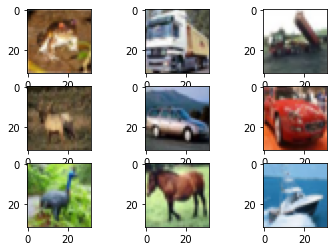

In [6]:
# Take a look at an example image from the data
for i in range(9):
  # create subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(x_train[i])

plt.show()

Okay, so very small, pixelated images.  But enough for the computer to learn the classes!  Let's try it.  Start small with a simple convolutional neural net, then later we will try augmentation and transfer learning.

In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

we will need to perform one hot encoding on this array utilizing the to_categorical() function

## Building a Test Harness ##

Modular code to repeat this process and test various features.  Will have Loading, Preprocessing, Defining the model, Evaluating the model, Visualizing results.

In [8]:
# Let's create a function to do load this all in one
def load_dataset():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  # keras utility function
  y_train = tf.keras.utils.to_categorical(y_train)
  y_test = tf.keras.utils.to_categorical(y_test)
  return x_train, y_train, x_test, y_test

In [9]:
# Preprocessing function
def data_preprocessing(x_train, x_test):
  # normalize pixel range to 0-1
  x_train = x_train / 255.0
  x_test = x_test / 255.0
  return x_train, x_test

In [10]:
# Function to define the CNN - leaving this blank as a template to be edited throughout
def define_model():
  model = tf.keras.Sequential()
  # Convolutional layers
  return model

In [11]:
# Visualization function
def visualize_model(history):
  # plot loss 
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')

  #plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')

  # display plot
  plt.show()

  # save plot to file
  filename = sys.argv[0].split('/')[-1]
  plt.savefig(filename + '_plot.png')
  plt.close()

In [12]:
# Put it all together into a test harness
# set default epochs and batches so this can be adjusted later
def run_test_harness(epochs=100,batches=64):
  # Time the run
  start = time.time()
  # Load dataset
  x_train, y_train, x_test, y_test = load_dataset()
  # preprocess data
  x_train, x_test = data_preprocessing(x_train, x_test)
  # define model
  model = define_model()
  # fit model
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_data=(x_test,y_test),verbose=0,workers=-1,use_multiprocessing=True)
  # evaluate model
  _, acc = model.evaluate(x_test,y_test,verbose=0)
  # stop the timer
  end = time.time()
  seconds = end - start
  # Output
  print('> Test Accuracy: %.3f' % (acc * 100))
  print(f'> Test Harness Run Time: {seconds} seconds ({seconds / 60} minutes)')
  # learning curves
  visualize_model(history)

Okay perfect, we now have everything set up in a fashion that can be easily ran and modified to compare various approaches.

Starting with the general principals of the VGG models stacking convolutional layers using 3x3 filters and padding to ensure feature maps match inputs.  Let's try a 3-block VGG style

In [13]:
loss = 'categorical_crossentropy'

In [14]:
# Function to define the CNN
def define_model():
  model = tf.keras.Sequential()
  # Convolutional layers with relu activation and he_uniform initialization
  # block 1
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # block 2
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # block 3
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # Flatten
  model.add(Flatten())
  # Hidden layers
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  #compile model using Stochiastic Gradient Descent
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
  return model

> Test Accuracy: 74.610
> Test Harness Run Time: 13567.173281669617 seconds (226.11955469449362 minutes)


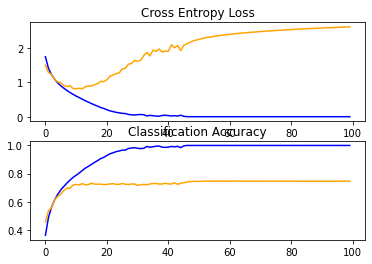

In [15]:
# let's see how this one goes!
run_test_harness()

Okay, ~75% for a baseline is okay, but looking at our learning curves we can tell there is room to improve.  The Loss functions diverging and the overfitting can be improved.  Let's see how we can improve this with some basic techniques.

## Regularization ##

We will start with dropout regularization.  Briefly, what this does is randomly drops individual neurons within layers to prevent the model from overfitting.

In [16]:
# Let's add some dropout regularization to the model
# 0.2 which means drop 20% of the neurons at random
def define_model():
  model = tf.keras.Sequential()
  # Convolutional layers with relu activation and he_uniform initialization
  # block 1
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # Add dropout
  model.add(Dropout(0.2))
  # block 2
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # Dropout
  model.add(Dropout(0.2))
  # block 3
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # Dropout
  model.add(Dropout(0.2))
  # Flatten
  model.add(Flatten())
  # Hidden layers
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # Dropout
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  #compile model using Stochiastic Gradient Descent
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
  return model

> Test Accuracy: 83.380
> Test Harness Run Time: 12972.991628170013 seconds (216.2165271361669 minutes)


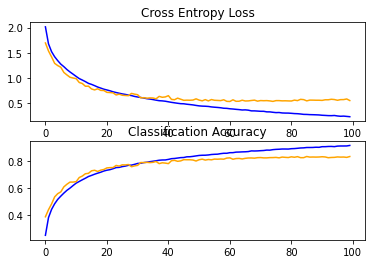

In [17]:
# Run the test again with updated model
run_test_harness()

Excellent!  The curves look much improved, and the accuracy jumped by nearly 10% points!  Let's take a look at some other methods of optimizing this model.

## Weight Decay ##

This is a common regularization technique which will effectively penalize the model in relation to the weights.

In [18]:
# Update baseline model with L2 weight regularization using the kernel regularizer
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

> Test Accuracy: 74.790
> Test Harness Run Time: 12180.628433942795 seconds (203.0104738990466 minutes)


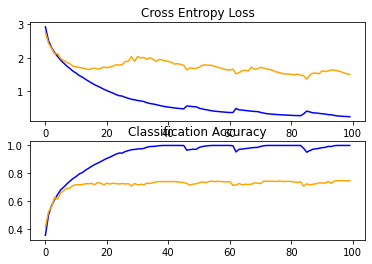

In [19]:
run_test_harness()

Not great...curves don't look much better than the baseline model either.  Let's toss this idea.

## Data Augmentation ##

One of the challenges of computer vision is acquiring a robust training dataset for you problem space.  One way this can be addressed is by augmenting our dataset with a variety of artificial images generated from the training dataset by performing rotations, flipping along axis, slightly shifting an image, zooming or cropping, etc. to take a small dataset of a class and artificially expand it.  Let's try it now

In [20]:
# Set up a new test harness with data agumentation
def run_augmented_test_harness(epochs=100, batches=64, save_name='default'):
  # Time the run
  start = time.time()
  # Load dataset
  x_train, y_train, x_test, y_test = load_dataset()
  # preprocess data
  x_train, x_test = data_preprocessing(x_train, x_test)
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=20, shear_range=0.1)
  # Prepare iterator
  train_iter = datagen.flow(x_train, y_train, batch_size=batches)
  # fit model
  steps = int(x_train.shape[0] / 64)
  history = model.fit(train_iter, steps_per_epoch=steps, epochs=epochs, validation_data=(x_test,y_test), verbose=0, workers=-1,use_multiprocessing=True)
  # save model
  model.save(f'{save_name}_final_model.h5')
  # evaluate model
  _, acc = model.evaluate(x_test,y_test,verbose=0)
  # stop the timer
  end = time.time()
  seconds = end - start
  # Output
  print('> Test Accuracy: %.3f' % (acc * 100))
  print(f'> Test Harness Run Time: {seconds} seconds ({seconds / 60} minutes)')
  # learning curves
  visualize_model(history)

> Test Accuracy: 83.710
> Test Harness Run Time: 14097.897202014923 seconds (234.96495336691538 minutes)


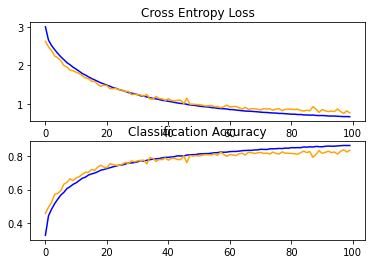

In [21]:
run_augmented_test_harness(save_name='augmentation')

Great!  The curves look much improved and the score jumped up to 82.4%.  It did come at a significant increase in runtime, however.  That is due to the significantly increased training data with the augmentation.

Although weight decay did not help, it looks like a combination of dropout and data augmentation should improve the model further.

## Continued Improvements - Batch Normalization ##

As we can see, with our curves looking good like this we could improve our accuracy by allowing our model to train longer (increasing epochs) and adding <b>Batch Normalization</b> to stabilize the learning process.

Additionally, we can increase the dropout regularization by adjusting the percentages throughout the layers.

Let's put it all together!  Increase dropout, add batch normalization, data augmentation, and train the model for 500 epochs.

**Performance recap -**
- Baseline - 75%
- Dropout - 83%
- Weight Decay - 75%
- Augmentation - 84%

In [22]:
# Add batch normalization and dropout to the model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

> Test Accuracy: 88.250
> Test Harness Run Time: 72809.46787691116 seconds (1213.4911312818526 minutes)


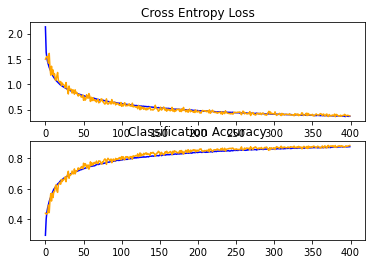

In [23]:
run_augmented_test_harness(epochs=400, save_name='sgd')

Awesome!  The model has really improved!  Now once again, it did come at a big runtime cost which always needs to be weighed.  Let's recap performance:
(Note, results may vary if you run this notebook again due to the SGD optimizer)

- Baseline: 75%
- Dropout: 84%
- Weight Decay: 72%
- Data Augmentation: 82%
- Dropout + Batch Normalization + Data Augmentation + Longer Training: 87%

It may be worth exploring the Adam optimizer which uses an adaptive learning rate technique to tune the model, but for now let's pickle this one and save it!  The pickling occurs within the test harness, and it will allow the model to be used in other notebooks without having to spend all the time training it!

In [1]:
def run_example(opt,filename):
  # load image
  img = image.load_img(filename, target_size=(32,32))
  
  # Display image
  plt.imshow(img)
  plt.show()
    
  # convert to array
  img = image.img_to_array(img)

  # reshape into single sample with 3 channels
  img = img.reshape(1, 32, 32, 3)
  # prepare pixels
  img = img / 255.

  # Load model
  model = load_model(f'models/{opt}_final_model.h5')
  # Make prediction
  result = model.predict_classes(img,batch_size=64)
  print(result)

Let's make some predictions now

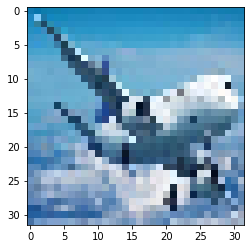

[0]


In [52]:
run_example('sgd','test_photos/airplane1.jpeg')

0 - airplane

Awesome!  We can now import a new color photo of any size and predict the class using our saved model.  As it is, it will output the class and will need to be converted back.  Recall:

- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck

Let's try a classic, cat photo!

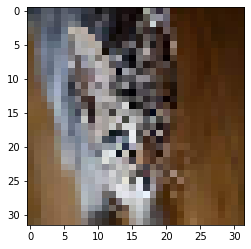

[3]


In [53]:
run_example('sgd','test_photos/cat_1.jpeg')

3: Cat - Amazing!

We now have a functioning, tuned image classifier already.  That really is awesome!

Let's see how the adam optimizer performs.

In [55]:
# Add batch normalization and dropout to the model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
	return model

> Test Accuracy: 90.030
> Test Harness Run Time: 80485.30539011955 seconds (1341.4217565019926 minutes)


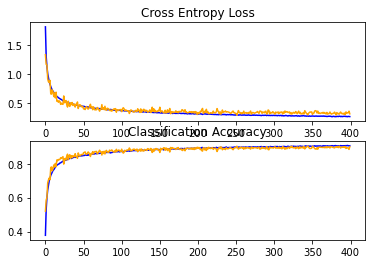

In [56]:
run_augmented_test_harness(epochs=400, save_name='adam')

Great!  The Adam optimizer improved even further!  The Adam optimizer has become very popular today due to it's adaptive learning rate and improved performance on sparse datasets.

Review Performance Evolution:
- 75% - Baseline
- 84% - Dropout
- ~~76% - Weight Decay~~ 
- 82% - Data Augmentation 
- 87% - SGD: Dropout + Batch Normalization + Data Augmentation + Longer Training
- 90% - Adam: Dropout + Batch Normalization + Data Augmentation + Longer Training 

All told the notebook takes about 6 hours to run using a GPU on Google Colab.

It takes way longer using my own CPU on my 3 year old macbook... 

Improving a baseline model from 75% to 90%, not bad for a days work!

In [57]:
notebook_end = time.time()

notebook_runtime_seconds = notebook_end - notebook_start
notebook_runtime_minutes = notebook_runtime_seconds / 60
notebook_runtime_hours = notebook_runtime_minutes / 60

print(f'> Notebook Total Run Time: {notebook_runtime_minutes} minutes ({notebook_runtime_hours} hours')

> Notebook Total Run Time: 3741.9159674684206 minutes (62.36526612447368 hours


Wow...it takes nearly 10 times longer to run on an average CPU!  2.6 DAYS! 

Incredible.  And to think it is now as simple as just running the notebook on Google Colab and activating a GPU instance.